In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip './drive/My Drive/dataset/cifar.zip'

#Dataset

In [0]:
import torch
from torch.utils.data.dataset import Dataset

import torchvision
import torchvision.transforms as transforms

import os

from PIL import Image

class read_dataset(Dataset):
    def __init__(self,data_dir):
        self.data_list=[data_dir+file_name for file_name in os.listdir(data_dir)]
        self.transform=transforms.Compose([transforms.Resize((64,64)),
                                           transforms.ToTensor()])
        self.transform_grayscale=transforms.Compose([transforms.Resize((64,64)),
                                                     transforms.Grayscale(1),
                                                     transforms.ToTensor()])
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,index):
        img=Image.open(self.data_list[index])
        img_grayscale=self.transform_grayscale(img)
        img=self.transform(img)
        label=torch.ones(1)
        return img,img_grayscale,label

#Model

In [0]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,64,4,2,1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128,4,2,1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,256,4,2,1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,512,4,2,1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512,1,4,1,0),
            nn.Sigmoid()
        )
    def forward(self,x):
        out=self.layer(x)
        return out

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1=nn.Sequential(nn.Conv2d(1,64,4,2,1)) # 32
        self.layer2=nn.Sequential(nn.Conv2d(64,128,4,2,1)) # 16
        self.layer3=nn.Sequential(nn.Conv2d(128,256,4,2,1)) # 8
        self.layer4=nn.Sequential(nn.Conv2d(256,512,4,2,1)) # 4
        self.layer5=nn.Sequential(nn.ConvTranspose2d(512,256,4,2,1)) # 8
        self.layer6=nn.Sequential(nn.ConvTranspose2d(512,128,4,2,1)) # 16
        self.layer7=nn.Sequential(nn.ConvTranspose2d(256,64,4,2,1)) # 32
        self.layer8=nn.Sequential(nn.ConvTranspose2d(128,3,4,2,1)) # 64
        self.leakyrelu=nn.Sequential(nn.LeakyReLU(0.2))
        self.relu=nn.Sequential(nn.ReLU())
        self.tanh=nn.Sequential(nn.Tanh())

    def forward(self,x):
        backup1=self.layer1(x) # 32
        out=self.leakyrelu(backup1)
        
        backup2=self.layer2(out) # 16
        out=self.leakyrelu(backup2)
        
        backup3=self.layer3(out) # 8
        out=self.leakyrelu(backup3)
        
        out=self.layer4(out) # 4
        out=self.leakyrelu(out)
        
        out=self.layer5(out) # 8
        out=self.relu(out)
                
        out=self.layer6(torch.cat([out,backup3],1))
        out=self.relu(out)
        
        out=self.layer7(torch.cat([out,backup2],1))
        out=self.relu(out)
        
        out=self.layer8(torch.cat([out,backup1],1))
        out=self.tanh(out)
        
        return out

#Training

In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader

# 디바이스 식별

device='cuda' if torch.cuda.is_available() else 'cpu'

if __name__=='__main__':
    batch_size=64
    
    # 트레이닝 데이터 로드

    train_data=read_dataset('./cifar/')
    train_set=DataLoader(train_data,batch_size,True)

    # 트레이닝

    learning_rate=0.0002
    training_epochs=10

    d_net=Discriminator().to(device)
    g_net=Generator().to(device)

    criterion=nn.MSELoss()
    loss_calculation=nn.L1Loss()
    
    d_optimizer=optim.Adam(d_net.parameters(),learning_rate)
    g_optimizer=optim.Adam(g_net.parameters(),learning_rate)

    print('Learning started. It takes sometime.')

    for epoch in range(training_epochs):
        for X,Z,Y in train_set:
            X=X.to(device)
            batch_size=X.size(0)
            Z=Z.to(device)
            Y=Y.squeeze().to(device)

            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
                        
            hypothesis=d_net(X).squeeze()
            d_cost_real=criterion(hypothesis,Y)
            
            fake_images=g_net(Z)
            hypothesis=d_net(fake_images).squeeze()
            d_cost_fake=criterion(hypothesis,
                                  torch.zeros(batch_size).squeeze().to(device))
            d_cost=d_cost_real+d_cost_fake
            
            d_cost.backward(retain_graph=True)
            d_optimizer.step()
            
            original_cost=loss_calculation(fake_images,X)
            g_cost=criterion(hypothesis,Y)+original_cost*10

            g_cost.backward(retain_graph=True)
            g_optimizer.step()

        # 트레이닝 데이터 저장

        torch.save(g_net.state_dict(),'./model_epoch_%d.pth'%(epoch+1))
    
    print('Learning Finished!')

Learning started. It takes sometime.
Learning Finished!


#Test

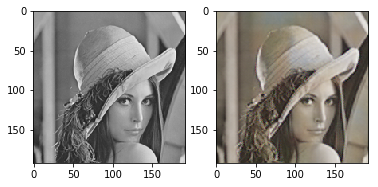

In [23]:
from matplotlib import pyplot as plt

transform=transforms.Compose([transforms.Grayscale(1),transforms.ToTensor()])

if __name__=='__main__':
    net=Generator()

    # 네트워크 데이터 로드

    load_net='./model_epoch_10.pth'
    net.load_state_dict(torch.load(load_net))

    with torch.no_grad():
        test_img=Image.open('./Lena.png')
        h,w=test_img.size
        test_img=test_img.crop((0,0,int(h/64)*64,int(w/64)*64))
        z=transform(test_img)
        fake_image=net(z.unsqueeze(0))
        
        fig=plt.figure()
        ax1=fig.add_subplot(1,2,1)
        ax2=fig.add_subplot(1,2,2)
        
        ax1.imshow(test_img,'gray')
        ax2.imshow(fake_image.squeeze().permute(1,2,0).numpy().clip(0,1))
        
        plt.show()